In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import json
import cv2
from pycocotools.coco import COCO
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
#import colormap as cmap
import numpy as np

def horisontal_flip(images, targets):
    images = torch.flip(images, [-1])
    targets[2] = 1 - targets[2]
    return images, targets

def visualize(index, masks, bounding_boxes, augment):
    image = coco.loadImgs(coco.getImgIds()[index])[0]    
    anno_ids = coco.getAnnIds(imgIds=[image["id"]])
    annos = coco.loadAnns(anno_ids) 
    #print( annos )
    """new_annos = []
    for single in annos:
        single = get_angles(single)
        new_annos.append([single])
    
    annos = new_annos"""
    filename = os.path.join(data_folder,image["file_name"])
    #print(filename)
    img = cv2.imread(str(filename))
    print(img.shape)
            
    for anno in annos:
        #print(anno)
        anno = get_angles(anno)
        if augment:
            if np.random.random() < 0.5:
                box = anno['bbox']
                img, anno = horisontal_flip(torch.Tensor(img), box)
                anno['bbox'] = anno
        
        #c = tuple([int(x) for x in anno["category_id"]])         
        if masks:
            points = np.array(anno["segmentation"], dtype=np.int32).reshape(1,-1,2)
            img = cv2.polylines(img, points, True, 3)
        
        if bounding_boxes:  
                x,y,w,h,a = np.array(anno["bbox"]).astype(np.int32)
                #img = cv2.rectangle(img, (x,y),(x + w,y + h),(0,255,255), 3) 
                img = draw_xywha(img,x,y,w,h,a)
                cat = coco.cats[anno['category_id']]['name']
                cv2.putText(img, cat, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX ,  0.8, 1, cv2.LINE_AA)            
                
    
    plt.imshow(img[...,::-1])
    plt.axis("off")
    plt.grid(False)
    plt.tight_layout()

def get_angles(ann):
    
    #print(ann['bbox'])
    img_id = ann['image_id']
    new_ann = None
    # get width and height
    if not 'rbbox' in ann:
        # using COCO dataset. 4 = [x1,y1,w,h]
        coco = True
        # convert COCO format: x1,y1,w,h to x,y,w,h
        ann['bbox'][0] = ann['bbox'][0] + ann['bbox'][2] / 2
        ann['bbox'][1] = ann['bbox'][1] + ann['bbox'][3] / 2
        ann['bbox'].append(0)
        if ann['bbox'][2] > ann['bbox'][3]:
            ann['bbox'][2],ann['bbox'][3] = ann['bbox'][3],ann['bbox'][2]
            ann['bbox'][4] -= 90
        new_ann = ann['bbox']
    else:
        # using rotated bounding box datasets. 5 = [cx,cy,w,h,angle]
        assert len(ann['rbbox']) == 5, 'Unknown bbox format' # x,y,w,h,a
        new_ann = ann['rbbox']
        

        if new_ann[2] > new_ann[3]:
            new_ann[2], new_ann[3] = new_ann[3],new_ann[2]
            new_ann[4] -= 90 if new_ann[4] > 0 else -90

    if new_ann[2] == new_ann[3]:
        new_ann[3] += 1 # force that w < h
        
    new_ann[4] = np.clip(new_ann[4], -90.0, 90.0 - 1e-14)

    assert new_ann[2] < new_ann[3]
    assert new_ann[4] >= -90 and new_ann[4] < 90

    # override original bounding box with rotated bounding box
    ann['bbox'] = torch.Tensor(new_ann)
    #print(ann['bbox'])
    return ann

    
def draw_xywha(im, x, y, w, h, angle, color=(255,0,0), linewidth=5):
    '''
    im: image numpy array, shape(h,w,3), RGB
    angle: degree
    '''
    c, s = np.cos(angle/180*np.pi), np.sin(angle/180*np.pi)
    R = np.asarray([[c, s], [-s, c]])
    pts = np.asarray([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
    rot_pts = []
    for pt in pts:
        rot_pts.append(([x, y] + pt @ R).astype(int))
    contours = np.array([rot_pts[0], rot_pts[1], rot_pts[2], rot_pts[3]])
    cv2.polylines(im, [contours], isClosed=True, color=color,
                thickness=linewidth, lineType=cv2.LINE_4)
    return im
    
    
data_folder = "/localdata/saurabh/dataset/FES/JPEGImages/"
coco = COCO("/localdata/saurabh/dataset/FES/coco/annotations/instances_default_with_rbbox.json")
#data_folder = "/localdata/saurabh/dataset/omnidetector-Flat_(Record_01)/JPEGImages/"
#coco = COCO("/localdata/saurabh/dataset/omnidetector-Flat_(Record_01)/coco/annotations/instances_training.json")
plt.figure(figsize=(100,100))
total = len(coco.getImgIds()) - 1

interact(visualize, index=widgets.IntSlider(min=0, max=total, step=1, continuous_update=False), masks=False, bounding_boxes=True, augment=False);  
plt.show()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


<Figure size 7200x7200 with 0 Axes>

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=300), Checkbox(valu…

## Split Data

In [1]:
import os
import json
import numpy as np
import glob
import cv2
import tqdm

image_paths = glob.glob(f"/localdata/saurabh/yolov3/data/custom/images/person/*")


In [2]:
train_split = image_paths[:49400]
val_split = image_paths[49400:49700]
test_split = image_paths[49700:]

In [5]:
folders = [ val_split, test_split] #train_split,
sets = [ 'val', 'test'] #'train',

for fol, ty in zip(folders, sets):
    for jin in tqdm.tqdm(fol, desc=f'creating {ty} dataset'):
        image = cv2.imread(jin, 1)
        
        output_dir = jin.replace('person', ty)
        
        cv2.imwrite(output_dir, image)
        
#         print(j)
        
        
#     print(ty)
#     break

creating test dataset: 100%|██████████| 300/300 [00:26<00:00, 11.30it/s]


In [39]:
folders

[['/localdata/saurabh/yolov3/data/custom/images/person/0049034_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0019651_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0017274_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0002940_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0039360_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0005186_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0031483_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0013012_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0009331_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0044651_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0001414_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0009542_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/person/0041770_img.png',
  '/localdata/saurabh/yolov3/data/custom/images/per

# Make the data files

In [3]:
######## NOTE #######
'''Last performed for FES dataset. The logic differes slightly for other datasets. 
Take care of image extensions and image_names variable during implementation.
Logic of load annotation is verified. 
Do visualize the targets before training to check if correct annotations are saved'''
####### NOTE ######
import glob
from collections import defaultdict
import os
import json
import numpy as np
import cv2
from PIL import Image
import torch
import tqdm

###Input####
mode_in = 'all_class'   ### ['train', 'val', 'person', 'all_class']
dataset = 'DST'   ### ['coco', 'DST', 'fes', 'custom', 'cepdof', 'mwr']
get_angle = False
image_paths = glob.glob(f"/localdata/saurabh/yolov3/data/{dataset}/images/person/*")
#image_paths = glob.glob('/localdata/saurabh/dataset/DST/val/*.png')   ### for DST dataset
############


image_ids = []
image_names = []
#print(image_paths[0])
##### Edit this part according to the name of the files ####
for image in image_paths:
    #print(image)
    image_name, image_ext = os.path.splitext(os.path.basename(image))
    #print(image_name)
    image_names += [image_name]
    #print(image_name)
    #image_name = image_name.split('_')[1]     # Varies according to databases. Check if name is correct wrt to anno
    image_ids += [image_name]     # If image_ids != image_names, execute the function below to get sequential image ids
    #break
    
#print(image_ids)

In [4]:
len(image_ids)

629

In [5]:
image_ids

['Record_00444',
 'Record_01386',
 'Record_00993',
 'Record_00282',
 'Record_00519',
 'Record_01218',
 'Record_00843',
 'Record_00597',
 'Record_01764',
 'Record_01575',
 'Record_01776',
 'Record_01632',
 'Record_00615',
 'Record_00153',
 'Record_00084',
 'Record_01290',
 'Record_01749',
 'Record_00549',
 'Record_01716',
 'Record_00741',
 'Record_01446',
 'Record_00618',
 'Record_01155',
 'Record_01215',
 'Record_01086',
 'Record_00747',
 'Record_00870',
 'Record_01530',
 'Record_00171',
 'Record_00564',
 'Record_00543',
 'Record_01362',
 'Record_00609',
 'Record_01248',
 'Record_00852',
 'Record_01866',
 'Record_01347',
 'Record_00336',
 'Record_01245',
 'Record_01434',
 'Record_00342',
 'Record_00936',
 'Record_00393',
 'Record_00639',
 'Record_01533',
 'Record_01611',
 'Record_01278',
 'Record_00267',
 'Record_00933',
 'Record_01728',
 'Record_00828',
 'Record_01203',
 'Record_00174',
 'Record_01491',
 'Record_00834',
 'Record_00966',
 'Record_00573',
 'Record_01344',
 'Record_00090

In [6]:
#### Process and load annotatinos according to RAPID implementation
if get_angle == True:
    def load_anns(img_dir,json_path):
            coco = False
            print(f'Loading annotations {json_path} into memory...')
            with open(json_path, 'r') as f:
                json_data = json.load(f)

            for ann in json_data['annotations']:
                img_id = ann['image_id']
                #print(img_id)
                new_ann = None
                # get width and height 
                if not 'rbbox' in ann:    ## not 'rbbox'
                    # using COCO dataset. 4 = [x1,y1,w,h]
                    coco = True
                    ann['bbox'][0] = ann['bbox'][0] + ann['bbox'][2] / 2
                    ann['bbox'][1] = ann['bbox'][1] + ann['bbox'][3] / 2
                    ann['bbox'].append(0)
                    if ann['bbox'][2] > ann['bbox'][3]:
                        ann['bbox'][2],ann['bbox'][3] = ann['bbox'][3],ann['bbox'][2]
                        ann['bbox'][4] -= 90
                    new_ann = ann['bbox']
                else:
                    # using rotated bounding box datasets. 5 = [cx,cy,w,h,angle]
                    assert len(ann['rbbox']) == 5, 'Unknown bbox format' # x,y,w,h,a
                    new_ann = ann['rbbox']


                    if new_ann[2] > new_ann[3]:
                        new_ann[2], new_ann[3] = new_ann[3],new_ann[2]
                        new_ann[4] -= 90 if new_ann[4] > 0 else -90

                if new_ann[2] == new_ann[3]:
                    new_ann[3] += 1 # force that w < h

                new_ann[4] = np.clip(new_ann[4], -90.0, 90.0 - 1e-14)

                assert new_ann[2] < new_ann[3]
                assert new_ann[4] >= -90 and new_ann[4] < 90

                # override original bounding box with rotated bounding box
                ann['bbox'] = torch.Tensor(new_ann)
                #print(img_id)
                imgid2anns[img_id].append(ann)

            for img in json_data['images']:
                img_id = img['id']
                #print(img_id)
                assert img_id not in imgid2path
                anns = imgid2anns[img_id]
                # if there is crowd gt, skip this image
                if coco and any(ann['iscrowd'] for ann in anns):
                    continue

                img_ids.append(img_id)
                imgid2path[img_id] = os.path.join(img_dir, img['file_name'])
                imgid2info[img['id']] = img

            catids = [cat['id'] for cat in json_data['categories']]

###For bounding boxes with angle 0
else:
    def load_anns(img_dir,json_path):
            coco = False
            print(f'Loading annotations {json_path} into memory...')
            with open(json_path, 'r') as f:
                json_data = json.load(f)

            for ann in json_data['annotations']:
                img_id = ann['image_id']
                #print(img_id)
                new_ann = None
                # get width and height 
                if 'bbox' in ann:    ## not 'rbbox'
                    # using COCO dataset. 4 = [x1,y1,w,h]
                    coco = True
                    ann['bbox'][0] = ann['bbox'][0] + ann['bbox'][2] / 2
                    ann['bbox'][1] = ann['bbox'][1] + ann['bbox'][3] / 2
                    ann['bbox'].append(0)
    #                 if ann['bbox'][2] > ann['bbox'][3]:
    #                     ann['bbox'][2],ann['bbox'][3] = ann['bbox'][3],ann['bbox'][2]
    #                     ann['bbox'][4] -= 90
                    new_ann = ann['bbox']
                else:
                    # using rotated bounding box datasets. 5 = [cx,cy,w,h,angle]
                    assert len(ann['rbbox']) == 5, 'Unknown bbox format' # x,y,w,h,a
                    new_ann = ann['rbbox']


                    if new_ann[2] > new_ann[3]:
                        new_ann[2], new_ann[3] = new_ann[3],new_ann[2]
                        new_ann[4] -= 90 if new_ann[4] > 0 else -90

                if new_ann[2] == new_ann[3]:
                    new_ann[3] += 1 # force that w < h

    #             new_ann[4] = np.clip(new_ann[4], -90.0, 90.0 - 1e-14)

    #             assert new_ann[2] < new_ann[3]
    #             assert new_ann[4] >= -90 and new_ann[4] < 90

                # override original bounding box with rotated bounding box
                ann['bbox'] = torch.Tensor(new_ann)
                #print(img_id)
                imgid2anns[img_id].append(ann)

            for img in json_data['images']:
                img_id = img['id']
                #print(img_id)
                assert img_id not in imgid2path
                anns = imgid2anns[img_id]
                # if there is crowd gt, skip this image
                if coco and any(ann['iscrowd'] for ann in anns):
                    continue

                img_ids.append(img_id)
                imgid2path[img_id] = os.path.join(img_dir, img['file_name'])
                imgid2info[img['id']] = img

            catids = [cat['id'] for cat in json_data['categories']]

In [7]:
### Store the required values generated during load_anns function
coco =  False
img_ids = []
imgid2info = dict()
imgid2path = dict()
imgid2anns = defaultdict(list)
catids = []

if dataset == 'DST':
    load_anns("/localdata/saurabh/dataset/DST/val/", "/localdata/saurabh/dataset/DST/instances_val_with_rbbox.json" )
elif dataset == 'custom':
    load_anns("/localdata/saurabh/dataset/theodore_v3/images/", "/localdata/saurabh/dataset/theodore_v3/coco/annotations/instances.json")
elif dataset == 'fes':
    load_anns("/localdata/saurabh/dataset/fes/val/", "/localdata/saurabh/dataset/FES/coco/annotations/instances_default_with_rbbox.json" )
elif dataset == 'coco':
    load_anns("/localdata/saurabh/yolov3/data/coco/images/train2017/","/localdata/saurabh/yolov3/data/coco/labels/annotations/instances_train2017.json")
elif dataset == 'cepdof':
    load_anns("/localdata/saurabh/yolov3/data/cepdof/images/person/","/localdata/saurabh/dataset/CEPDOF/coco/annotations/instances_with_rbbox.json")
elif dataset == 'mwr':
    load_anns("/localdata/saurabh/yolov3/data/mwr/images/person/","/localdata/saurabh/dataset/MW-R/annotations/instances_with_rbbox.json")

Loading annotations /localdata/saurabh/dataset/DST/instances_val_with_rbbox.json into memory...


In [8]:
len(img_ids)

629

In [9]:
img_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [10]:
#### Run this to get image_ids in sequence starting with 1 #####
'''Do not run if img_id=image_name'''

image_ids = []
if dataset == 'custom':
    for i in range(len(imgid2info)):
        file_name = imgid2info[i]['file_name'].split('.')[0]
        #i_d = imgid2info

        if file_name in image_names:  # Make sure names in both list are identical
            image_ids += [i]
            print(file_name, i)
else:
    for i in range(1,len(imgid2info)):
        file_name = imgid2info[i]['file_name'].split('.')[0]
        #i_d = imgid2info

        if file_name in image_names:  # Make sure names in both list are identical
            image_ids += [i]
            print(file_name, i)

Record_00063 1
Record_00066 2
Record_00069 3
Record_00072 4
Record_00075 5
Record_00078 6
Record_00081 7
Record_00084 8
Record_00087 9
Record_00090 10
Record_00093 11
Record_00096 12
Record_00099 13
Record_00102 14
Record_00105 15
Record_00108 16
Record_00111 17
Record_00114 18
Record_00117 19
Record_00120 20
Record_00123 21
Record_00126 22
Record_00129 23
Record_00132 24
Record_00135 25
Record_00138 26
Record_00141 27
Record_00144 28
Record_00147 29
Record_00150 30
Record_00153 31
Record_00156 32
Record_00159 33
Record_00162 34
Record_00165 35
Record_00168 36
Record_00171 37
Record_00174 38
Record_00177 39
Record_00180 40
Record_00183 41
Record_00186 42
Record_00189 43
Record_00192 44
Record_00195 45
Record_00198 46
Record_00201 47
Record_00204 48
Record_00207 49
Record_00210 50
Record_00213 51
Record_00216 52
Record_00219 53
Record_00222 54
Record_00225 55
Record_00228 56
Record_00231 57
Record_00234 58
Record_00237 59
Record_00240 60
Record_00243 61
Record_00246 62
Record_00249 63
R

In [11]:
image_names = sorted(image_names) #if image_ids are sequential then sort the names accordingly

In [12]:
for a in zip(image_names, image_ids):
    print(a)

('Record_00063', 1)
('Record_00066', 2)
('Record_00069', 3)
('Record_00072', 4)
('Record_00075', 5)
('Record_00078', 6)
('Record_00081', 7)
('Record_00084', 8)
('Record_00087', 9)
('Record_00090', 10)
('Record_00093', 11)
('Record_00096', 12)
('Record_00099', 13)
('Record_00102', 14)
('Record_00105', 15)
('Record_00108', 16)
('Record_00111', 17)
('Record_00114', 18)
('Record_00117', 19)
('Record_00120', 20)
('Record_00123', 21)
('Record_00126', 22)
('Record_00129', 23)
('Record_00132', 24)
('Record_00135', 25)
('Record_00138', 26)
('Record_00141', 27)
('Record_00144', 28)
('Record_00147', 29)
('Record_00150', 30)
('Record_00153', 31)
('Record_00156', 32)
('Record_00159', 33)
('Record_00162', 34)
('Record_00165', 35)
('Record_00168', 36)
('Record_00171', 37)
('Record_00174', 38)
('Record_00177', 39)
('Record_00180', 40)
('Record_00183', 41)
('Record_00186', 42)
('Record_00189', 43)
('Record_00192', 44)
('Record_00195', 45)
('Record_00198', 46)
('Record_00201', 47)
('Record_00204', 48)
(

In [13]:
imgid2info[560] # just to cross check the image_id-image_name pair

{'width': 1200,
 'flickr_url': '',
 'license': 0,
 'date_captured': 0,
 'id': 560,
 'height': 1200,
 'file_name': 'Record_01740.png',
 'coco_url': ''}

In [13]:
imgid2anns[276893]

[{'segmentation': [[1.69,
    39.29,
    28.34,
    45.37,
    52.17,
    80.89,
    144.72,
    80.42,
    215.3,
    82.76,
    227.92,
    89.31,
    227.92,
    100.06,
    263.44,
    101.93,
    376.09,
    86.5,
    429.84,
    83.7,
    440.59,
    89.31,
    443.4,
    121.09,
    442.93,
    126.7,
    466.3,
    132.77,
    472.84,
    145.86,
    472.38,
    181.39,
    475.65,
    321.14,
    474.71,
    323.48,
    458.82,
    323.48,
    451.81,
    319.74,
    450.87,
    306.18,
    447.6,
    300.11,
    445.27,
    297.77,
    452.28,
    292.16,
    456.95,
    287.02,
    458.82,
    271.13,
    450.41,
    243.08,
    432.18,
    229.06,
    398.99,
    216.91,
    344.31,
    213.17,
    292.42,
    216.44,
    272.32,
    218.78,
    256.43,
    214.1,
    242.41,
    212.7,
    228.86,
    215.04,
    209.69,
    244.02,
    208.76,
    266.92,
    214.83,
    287.49,
    235.87,
    287.02,
    240.07,
    287.02,
    235.87,
    301.98,
    259.7,
    314.6,


In [14]:
#### Get annotations only for the train/val set according to image_ids
ind_path = [imgid2path[ids] for ids in image_ids]
annotations = [imgid2anns[ids] for ids in image_ids]

In [15]:
##### Map the labels to 0-indexed labels
label_map = {1:0, 2:1, 3:2, 4:3, 5:4, 6:5}

In [16]:
label_map[3]

2

In [15]:
os.path.splitext(os.path.basename(ind_path[0]))[0]

'0000000_img'

In [34]:
for i, anno in enumerate(annotations):
    if anno != []:
        valid = [ann['category_id'] for ann in anno]
        
        if 1 in valid:
            print(valid)
            print(ind_path[i])
        #break
        

[44, 67, 1, 49, 51, 51, 79, 1, 47, 47, 51, 51, 56, 50, 56, 56, 79, 57, 81]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000397133.jpg
[1, 1, 1, 28, 31, 47, 10]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000252219.jpg
[4, 4, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000480985.jpg
[1, 5, 1, 5, 33]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000348881.jpg
[9, 9, 9, 1, 9, 9, 9, 9, 15, 9, 1, 9, 9]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000522713.jpg
[20, 20, 20, 20, 1, 1, 1, 20, 20, 20, 20, 20, 20, 20, 20, 20]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000181666.jpg
[3, 3, 3, 3, 3, 3, 6, 1, 1, 3, 3, 3, 3, 3, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000017627.jpg
[6, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000143931.jpg
[6, 27, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 31, 1, 31, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000303818.jpg
[3, 3, 3, 6, 

[2, 9, 1, 1, 1, 1, 77, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000395180.jpg
[1, 1, 1, 2]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000472623.jpg
[72, 1, 81, 81]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000009772.jpg
[1, 1, 1, 70, 1, 1, 1, 1, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000056350.jpg
[4, 4, 4, 4, 1, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000534605.jpg
[4, 1, 1, 1, 1, 3, 3, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000433204.jpg
[4, 4, 4, 1, 1, 1, 1, 1, 8, 4, 4]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000245448.jpg
[4, 1, 1, 1, 3, 3, 31, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000224724.jpg
[19, 19, 1, 1, 1, 1, 1, 10, 27, 1, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000431876.jpg
[7, 7, 31, 1, 10, 1]
/localdata/saurabh/yolov3/data/coco/images/val2017/000000482585.jpg
[3, 3, 1, 1, 1, 3, 3, 3, 3]
/localdata/saurabh/yolov3/data/co

In [17]:
##### Save the paths to the images and annotations as .txt files
if mode_in == 'person':
    all_images = []
    text_names = open(f'/localdata/saurabh/yolov3/data/{dataset}/{mode_in}_paths.txt', "w")    ##2
    for i, ann in enumerate(tqdm.tqdm(annotations, desc='Save annotations')):
        file_name = os.path.splitext(os.path.basename(ind_path[i]))[0]     
        #### Append the path list
        text_names.write(f'/localdata/saurabh/yolov3/data/{dataset}/images/{mode_in}/{file_name}{image_ext}')
        text_names.write('\n')
        if ann != []:     ### only write files in not empty and have labels for person class
            valid = [anno['category_id'] for anno in ann]
            if 1 in valid:
                #### Open the label file for each anno
                if get_angle == True:
                    text_file = open(f'/localdata/saurabh/yolov3/data/{dataset}/labels/{mode_in}/{file_name}.txt', "w")    ##3
                else:
                    text_file = open(f'/localdata/saurabh/yolov3/data/{dataset}/labelsbbox/{mode_in}/{file_name}.txt', "w")
                for anno in ann:
                    #print(anno['category_id'])
                    if anno['category_id'] == 1:   ### save annotation only for person class
                        text_file.write("%i " %label_map[anno['category_id']])
                        text_file.writelines(["%f " % item  for item in anno['bbox']])
                        text_file.write("\n")

                text_file.close()
        #break
    text_names.close()

    print(file_name)
    
elif mode_in == 'all_class':
    all_images = []
#     text_names = open(f'/localdata/saurabh/yolov3/data/{dataset}/{mode_in}_paths.txt', "w")    ##2
    for i, ann in enumerate(tqdm.tqdm(annotations, desc='Save annotations')):
        file_name = os.path.splitext(os.path.basename(ind_path[i]))[0]     
        #### Append the path list
#         text_names.write(f'/localdata/saurabh/yolov3/data/{dataset}/images/person/{file_name}{image_ext}')
#         text_names.write('\n')
        if ann != []:     ### only write files in not empty and have labels for person class
            
            #### Open the label file for each anno
            if get_angle == True:
                text_file = open(f'/localdata/saurabh/yolov3/data/{dataset}/labels/{mode_in}/{file_name}.txt', "w")    ##3
            else:
                text_file = open(f'/localdata/saurabh/yolov3/data/{dataset}/labelsbbox/{mode_in}/{file_name}.txt', "w")
            for anno in ann:
                text_file.write("%i " %label_map[anno['category_id']])
                text_file.writelines(["%f " % item  for item in anno['bbox']])
                text_file.write("\n")

            text_file.close()
        #break
#     text_names.close()

    print(file_name)
    
else:
    all_images = []
    text_names = open(f'/localdata/saurabh/yolov3/data/{dataset}/{mode_in}_paths.txt', "w")    ##2
    for i, ann in enumerate(tqdm.tqdm(annotations, desc='Save annotations')):
        file_name = os.path.splitext(os.path.basename(ind_path[i]))[0]     
        #### Append the path list
        text_names.write(f'/localdata/saurabh/yolov3/data/{dataset}/images/{mode_in}/{file_name}{image_ext}')
        text_names.write('\n')
        if ann != []:     ### only write files in not empty and have labels for person class
            
            #### Open the label file for each anno
            if get_angle == True:
                text_file = open(f'/localdata/saurabh/yolov3/data/{dataset}/labels/{mode_in}/{file_name}.txt', "w")    ##3
            else:
                text_file = open(f'/localdata/saurabh/yolov3/data/{dataset}/labelsbbox/{mode_in}/{file_name}.txt', "w")
            for anno in ann:
                text_file.write("%i " %label_map[anno['category_id']])
                text_file.writelines(["%f " % item  for item in anno['bbox']])
                text_file.write("\n")

            text_file.close()
        #break
    text_names.close()

    print(file_name)

Save annotations: 100%|██████████| 628/628 [00:00<00:00, 3486.51it/s]

Record_01944


In [22]:
x = np.array([0,1,0.02, 0.1], dtype='float16')

# Convert rbbox to bbox

In [1]:
import glob
import numpy as np
import torch
from shapely.geometry import box
import os


def calculate_rotated(x, y, w, h, angle):
    '''
    angle: degree
    returns vertices of polygon in (x,y) form
    '''
    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor

    w = w.item()
    h = h.item()
    #w, h = w.numpy(), h.numpy()
    c, s = np.cos(angle.item()/180*np.pi), np.sin(angle.item()/180*np.pi)
    R = np.asarray([[c, s], [-s, c]])
    pts = np.asarray([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
    rot_pts = []
    for pt in pts:
        rot_pts.append(([x, y] + pt @ R).astype(float))
    contours = FloatTensor([rot_pts[0], rot_pts[1], rot_pts[2], rot_pts[3]])
    
    return contours

def xyxy2xywh(x):
    y = x.new(x.shape)
    w, h = x[..., 2] - x[..., 0], x[..., 3] - x[..., 1]
    y[...,0] = x[...,0] + (w / 2)
    y[...,1] = x[...,1] + (h / 2)
    y[...,2] = w
    y[...,3] = h
    return y


In [9]:
#### read images and label paths
img_path = sorted( glob.glob('/localdata/saurabh/yolov3/data/DST/images/person/*'), key=lambda x: os.path.splitext(os.path.basename(x))[0].split('_')[1])
lab_path = [im.replace('images','labels').replace('.jpg','.txt').replace('.png','.txt') for im in img_path]

In [10]:
lab_path

['/localdata/saurabh/yolov3/data/DST/labels/person/Record_00063.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00066.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00069.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00072.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00075.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00078.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00081.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00084.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00087.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00090.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00093.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00096.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00099.txt',
 '/localdata/saurabh/yolov3/data/DST/labels/person/Record_00102.txt',
 '/localdata/saurabh

In [11]:
for lab in lab_path:
    boxes = torch.from_numpy(np.loadtxt(lab).reshape(-1, 6))
    #print(boxes)
        
    bbox = boxes[...,1:]
    #print(bbox)
    new_box = []
    for bi, box in enumerate(bbox):
        bx, by, bw, bh, ba = box[0], box[1], box[2], box[3], box[4]
        box = calculate_rotated(bx,by,bw,bh,ba)
        
        b1_x1, b1_y1 = box.min(0)[0]
        b1_x2, b1_y2 = box.max(0)[0]
        
        box = xyxy2xywh( torch.Tensor([b1_x1, b1_y1, b1_x2, b1_y2]) )
        
        boxes[bi,1:5] = box 

        #break
    
    write_path = lab.replace('labels', 'labelsbbox')
    text_file = open(write_path, "w")
    for bi, box in enumerate(boxes):
        text_file.writelines(["%f " % item  for item in box])
        text_file.write("\n")
    
    text_file.close()
    
    
#     print(boxes)
#     print(ba)
#     print(lab)
    
#     break

<ipython-input-11-f35ba59531b7>:2: UserWarning: loadtxt: Empty input file: "/localdata/saurabh/yolov3/data/DST/labels/person/Record_00063.txt"
  boxes = torch.from_numpy(np.loadtxt(lab).reshape(-1, 6))


In [5]:
new_box

[]

In [55]:
def running_mean(x, N):
    """ x == an array of data. N == number of samples per average """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [107]:
import os
key_wrd = os.path.splitext( os.path.basename('run-minent9_134_val-tag-epoch_loss.csv') )[0].split('-')

In [108]:
key_wrd[1]

'minent9_134_val'

In [75]:
title_all ={'val_mAP': 'Validation mAP',
           'epoch_loss':'Validation loss'}

In [87]:
if not os.path.exists('plots/baselines_map.pdf'):
    print('Yaay')
else:
    print('noooo')

noooo


## Plot results

In [3]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for i, point in enumerate(scalars):
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

optbase4_epoch_loss


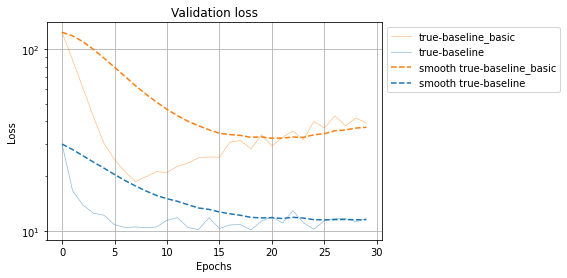

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import os

weig = 0.85
ml = 'l'

file_names = [f'basic_aug_{ml}', f'true_base_{ml}']

file1_path = 'plots/csv/' + exp_dict[file_names[0]]
file2_path = 'plots/csv/' + exp_dict[file_names[1]]


title_all ={'val_mAP': 'Validation mAP',
           'epoch_loss':'Validation loss',}
y_labels = {'val_mAP': 'mAP',
           'epoch_loss':'Loss'}

key_wrd = os.path.splitext( os.path.basename(file1_path) )[0].split('-')
metric = key_wrd[-1]
exp_name = key_wrd[1].split('_')[0]


csv_file1 = pd.read_csv(file1_path)
steps1 = csv_file1['Step']
val1 = csv_file1['Value']
raw1 = val1
val1 = smooth(scalars=val1, weight=weig)

csv_file2 = pd.read_csv(file2_path)
steps2 = csv_file2['Step']
val2 = csv_file2['Value']
raw2 = val2
val2 = smooth(val2, weig)
                          ###  orange ,  blue ,              
###default: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

plotcolor = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',]

if metric == 'val_mAP':
    plt.plot(steps1, raw1, color=plotcolor[1], alpha = 0.5, linewidth=0.7 )
    plt.plot(steps2, raw2, color=plotcolor[0], alpha = 0.5, linewidth=0.7 )

    plt.plot(steps1[:40], val1[:40], color=plotcolor[1], ls='--', )
    plt.plot(steps2, val2, color=plotcolor[0], ls='--', )
else:
    plt.semilogy(steps1, raw1, color=plotcolor[1], alpha = 0.5, linewidth=0.7 )
    plt.semilogy(steps2, raw2, color=plotcolor[0], alpha = 0.5, linewidth=0.7 )

    plt.semilogy(steps1[:40], val1[:40], color=plotcolor[1], ls='--', )
    plt.semilogy(steps2, val2, color=plotcolor[0], ls='--', )

# plt.ylim(0,100)
# plt.xlim(0,50)
# if y_labels[metric] == 'mAP':
#     plt.ylim(0,0.8)
# else:
#     plt.ylim(0,70)

legend_list = []

for fil in file_names:
#     print(fil)
    x = legend_dict[fil]
    legend_list += [x]
    
for fil in file_names:
#     print(fil)
    x = legend_dict[fil]
    legend_list += ['smooth '+ x]
    
plt.grid('on')
plt.xlabel('Epochs')
plt.ylabel(y_labels[metric])
plt.title(title_all[metric])
plt.legend(legend_list,bbox_to_anchor=(1.0,1.0), loc= 'upper left' )
# out_name = 'plots/'+exp_name+'_'+metric
out_name = 'plots/'+'aug_log'+'_'+metric
plt.tight_layout
if not os.path.exists(out_name+'.pdf'):
    plt.savefig(out_name+'.pdf', dpi=300, orientation='landscape', format='pdf', bbox_inches='tight')
print(exp_name+'_'+metric+'')
plt.show()

In [22]:
exp_dict = {
    'person_base_m': 'run-baseline9_147_val-tag-val_mAP.csv',
    'person_base_l': 'run-baseline9_147_val-tag-epoch_loss.csv',
    'optimal_perf_m': 'run-optbase1_160_val-tag-val_mAP.csv',
    'optimal_perf_l': 'run-optbase1_160_val-tag-epoch_loss.csv',
    'true_base_m': 'run-optbase5_207_val-tag-val_mAP.csv',
    'true_base_l': 'run-optbase5_207_val-tag-epoch_loss.csv',
    'basic_aug_m': 'run-optbase4_204_val-tag-val_mAP.csv',
    'basic_aug_l': 'run-optbase4_204_val-tag-epoch_loss.csv',
    'minent11_m': 'run-minent9_134_val-tag-val_mAP.csv',
    'minent12_m': 'run-minent17_143_val-tag-val_mAP.csv',
    'minent13_m': 'run-minent19_145_val-tag-val_mAP.csv',
    'minent14_m': 'run-minent20_150_val-tag-val_mAP.csv',
    'minent11_l': 'run-minent9_134_val-tag-epoch_loss.csv',
    'minent12_l': 'run-minent17_143_val-tag-epoch_loss.csv',
    'minent13_l': 'run-minent19_145_val-tag-epoch_loss.csv',
    'minent14_l': 'run-minent20_150_val-tag-epoch_loss.csv',
    'minent15_m': 'run-minent34_224_val-tag-val_mAP.csv',
    'minent15_l': 'run-minent34_224_val-tag-epoch_loss.csv',
    'person_base2_m': 'run-baseline14_223_val-tag-val_mAP.csv',
    'person_base2_l': 'run-baseline14_223_val-tag-epoch_loss.csv',
    'minent61_m': 'run-minent31_215_val-tag-val_mAP.csv',
    'minent62_m': 'run-minent25_168_val-tag-val_mAP.csv',
    'minent63_m': 'run-minent33_219_val-tag-val_mAP.csv',
    'minent61_l': 'run-minent31_215_val-tag-epoch_loss.csv',
    'minent62_l': 'run-minent25_168_val-tag-epoch_loss.csv',
    'minent63_l': 'run-minent33_219_val-tag-epoch_loss.csv',
    'fda61_m':'run-fda13_226_val-tag-val_mAP.csv',
    'fda62_m':'run-fda8_214_val-tag-val_mAP.csv',
    'fda63_m':'run-fda15_228_val-tag-val_mAP.csv',
    'fda64_m':'run-fda14_227_val-tag-val_mAP.csv',
    'fda65_m':'run-fda3norm_191_val-tag-val_mAP.csv',
    'fda66_m':'run-fda12norm_220_val-tag-val_mAP.csv',
    'fda61_l':'run-fda13_226_val-tag-epoch_loss.csv',
    'fda62_l':'run-fda8_214_val-tag-epoch_loss.csv',
    'fda63_l':'run-fda15_228_val-tag-epoch_loss.csv',
    'fda64_l':'run-fda14_227_val-tag-epoch_loss.csv',
    'fda65_l':'run-fda3norm_191_val-tag-epoch_loss.csv',
    'fda66_l':'run-fda12norm_220_val-tag-epoch_loss.csv',
    'lr1_m': 'run-baseline10_152_val-tag-val_mAP.csv',
    'lr2_m': 'run-baseline11_153_val-tag-val_mAP.csv',
    'lr3_m': 'run-baseline12_154_val-tag-val_mAP.csv',
    'lr4_m': 'run-baseline13_155_val-tag-val_mAP.csv',
    'lr1_l': 'run-baseline10_152_val-tag-epoch_loss.csv',
    'lr2_l': 'run-baseline11_153_val-tag-epoch_loss.csv',
    'lr3_l': 'run-baseline12_154_val-tag-epoch_loss.csv',
    'lr4_l': 'run-baseline13_155_val-tag-epoch_loss.csv',
    'fdanorm1_m': 'run-fda1norm_189_val-tag-val_mAP.csv',
    'fdanorm2_m': 'run-fda2norm_190_val-tag-val_mAP.csv',
    'fdanorm3_m': 'run-fda3norm_191_val-tag-val_mAP.csv',
    'fdanorm4_m': 'run-fda4norm_192_val-tag-val_mAP.csv',
    'fdanorm5_m': 'run-fda5norm_193_val-tag-val_mAP.csv',
    'fdanorm6_m': 'run-fda6norm_194_val-tag-val_mAP.csv',
    'fdanorm1_l': 'run-fda1norm_189_val-tag-epoch_loss.csv',
    'fdanorm2_l': 'run-fda2norm_190_val-tag-epoch_loss.csv',
    'fdanorm3_l': 'run-fda3norm_191_val-tag-epoch_loss.csv',
    'fdanorm4_l': 'run-fda4norm_192_val-tag-epoch_loss.csv',
    'fdanorm5_l': 'run-fda5norm_193_val-tag-epoch_loss.csv',
    'fdanorm6_l': 'run-fda6norm_194_val-tag-epoch_loss.csv',
    
}

legend_dict = {
    'person_base_m': 'person-baseline',
    'person_base_l': 'person-baseline',
    'optimal_perf_m': 'optimal-performance',
    'optimal_perf_l': 'optimal-performance',
    'true_base_m': 'true-baseline',
    'true_base_l': 'true-baseline',
    'basic_aug_m': 'true-baseline_basic',
    'basic_aug_l': 'true-baseline_basic',
    'minent11_m': 'minent1_1',
    'minent12_m': 'minent1_2',
    'minent13_m': 'minent1_3',
    'minent14_m': 'minent1_4',
    'minent11_l': 'minent1_1',
    'minent12_l': 'minent1_2',
    'minent13_l': 'minent1_3',
    'minent14_l': 'minent1_4',
    'minent15_m': 'minent1_5',
    'minent15_l': 'minent1_5',
    'person_base2_m': 'person-baseline_2',
    'person_base2_l': 'person-baseline_2',
    'minent61_m': 'minent6_1',
    'minent62_m': 'minent6_2',
    'minent63_m': 'minent6_3',
    'minent61_l': 'minent6_1',
    'minent62_l': 'minent6_2',
    'minent63_l': 'minent6_3',
    'fda61_m':'fda6_1',
    'fda62_m':'fda6_2',
    'fda63_m':'fda6_3',
    'fda64_m':'fda6_4',
    'fda65_m':'fda6_5',
    'fda66_m':'fda6_6',
    'fda61_l':'fda6_1',
    'fda62_l':'fda6_2',
    'fda63_l':'fda6_3',
    'fda64_l':'fda6_4',
    'fda65_l':'fda6_5',
    'fda66_l':'fda6_6',
    
}

In [154]:
rawnew = np.zeros(41)
rawnew[:11] = raw5[:11]
rawnew[11:] = raw2[:]
raw2 = rawnew
print(raw2)

[0.1333881  0.11271705 0.0971687  0.22249691 0.202812   0.28446588
 0.30267245 0.22528653 0.22431999 0.22165138 0.18268979 0.27285632
 0.36446401 0.38059881 0.28863788 0.36866921 0.2861082  0.51541507
 0.41066027 0.36493397 0.40317345 0.43771911 0.23250875 0.38790232
 0.39862329 0.27726951 0.4177058  0.22823827 0.34838012 0.36349598
 0.45597595 0.32028633 0.47910288 0.43593922 0.45999706 0.45013145
 0.44864669 0.30934933 0.37357685 0.50924861 0.36695161]


41

(41,) (41,)
fda8_epoch_loss


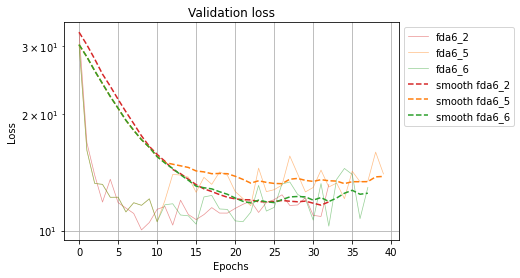

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np



weig = 0.85
trans = 0.5
join_2 = True
ml = 'l'

file_names = [ f'fda62_{ml}', f'fda65_{ml}', f'fda66_{ml}']

file1_path = 'plots/csv/' + exp_dict[file_names[0]]
file2_path = 'plots/csv/' + exp_dict[file_names[1]]
file3_path = 'plots/csv/' + exp_dict[file_names[2]]
file4_path = 'plots/csv/' + exp_dict[file_names[2]]
file5_path = 'plots/csv/' + exp_dict[file_names[2]]

title_all ={'val_mAP': 'Validation mAP',
           'epoch_loss':'Validation loss',}
y_labels = {'val_mAP': 'mAP',
           'epoch_loss':'Loss'}

key_wrd = os.path.splitext( os.path.basename(file1_path) )[0].split('-')
metric = key_wrd[-1]
exp_name = key_wrd[1].split('_')[0]

csv_file5 = pd.read_csv(file5_path)
steps5 = csv_file5['Step']
val5 = csv_file5['Value']
raw5 = val5
val5 = smooth(scalars=val5, weight=weig)

csv_file1 = pd.read_csv(file1_path)
steps1 = csv_file1['Step']
val1 = csv_file1['Value']
raw1 = val1
val1 = smooth(scalars=val1, weight=weig)

csv_file2 = pd.read_csv(file2_path)
steps2 = csv_file2['Step']
val2 = csv_file2['Value']
if join_2 == True:
    print(val2.shape, steps2.shape)
    rawnew = np.zeros(val2.shape[0] + 11)
    rawnew[:11] = raw5[:11]
    rawnew[11:] = val2[:]
    val2 = rawnew
    steps2 = np.arange(len(val2))
raw2 = val2
val2 = smooth(scalars=val2, weight=weig)

csv_file3 = pd.read_csv(file3_path)
steps3 = csv_file3['Step']
val3 = csv_file3['Value']
raw3 = val3
val3 = smooth(scalars=val3, weight=weig)

csv_file4 = pd.read_csv(file4_path)
steps4 = csv_file4['Step']
val4 = csv_file4['Value']
raw4 = val4
val4 = smooth(scalars=val4, weight=weig)


        ###  orange,     red,      green,     violet,     aqua
plotcolor = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',]

if metric == 'val_mAP':
    plt.plot(steps1[:40], raw1[:40], color=plotcolor[3], alpha = trans, linewidth=0.7 )
    plt.plot(steps2[:40], raw2[:40], color=plotcolor[1], alpha = trans, linewidth=0.7 )
    plt.plot(steps3, raw3, color=plotcolor[2], alpha = trans, linewidth=0.7 )
#     plt.plot(steps4, raw4, color=plotcolor[4], alpha = trans, linewidth=0.7 )
#     plt.plot(steps5, raw5, color=plotcolor[0], alpha = trans, linewidth=0.7 )
    
    plt.plot(steps1[:40], val1[:40], color=plotcolor[3], ls='--', )
    plt.plot(steps2[:40], val2[:40], color=plotcolor[1], ls='--', )
    plt.plot(steps3, val3, color=plotcolor[2], ls='--', )
#     plt.plot(steps4, val4, color=plotcolor[4], ls='--', )
#     plt.plot(steps5, val5, color=plotcolor[0], ls='--', )
    
elif metric == 'epoch_loss':
    plt.semilogy(steps1[:40], raw1[:40], color=plotcolor[3], alpha = trans, linewidth=0.7 )
    plt.semilogy(steps2[:40], raw2[:40], color=plotcolor[1], alpha = trans, linewidth=0.7 )
    plt.semilogy(steps3, raw3, color=plotcolor[2], alpha = trans, linewidth=0.7 )
#     plt.semilogy(steps4, raw4, color=plotcolor[4], alpha = trans, linewidth=0.7 )
#     plt.semilogy(steps5, raw5, color=plotcolor[0], alpha = trans, linewidth=0.7 )
    
    plt.semilogy(steps1[:40], val1[:40], color=plotcolor[3], ls='--', )
    plt.semilogy(steps2[:40], val2[:40], color=plotcolor[1], ls='--', )
    plt.semilogy(steps3, val3, color=plotcolor[2], ls='--', )
#     plt.semilogy(steps4, val4, color=plotcolor[4], ls='--', )
#     plt.semilogy(steps5, val5, color=plotcolor[0], ls='--', )

legend_list = []

for fil in file_names:
#     print(fil)
    x = legend_dict[fil]
    legend_list += [x]
    
for fil in file_names:
#     print(fil)
    x = legend_dict[fil]
    legend_list += ['smooth '+ x]

# plt.ylim(0,100)
# plt.xlim(0,50)
# if y_labels[metric] == 'mAP':
#     plt.ylim(0,0.8)
# else:
#     plt.ylim(0,70)
plt.grid('on')
plt.xlabel('Epochs')
plt.ylabel(y_labels[metric])
plt.title(title_all[metric])
plt.legend(legend_list, bbox_to_anchor=(1.0,1.0), loc= 'upper left')
# out_name = 'plots/'+exp_name+'_'+metric
out_name = 'plots/'+'fda62n'+'_'+metric#+str(trans)
plt.tight_layout
if not os.path.exists(out_name+'.pdf'):
    plt.savefig(out_name+'.pdf', dpi=300, orientation='landscape', format='pdf',  bbox_inches='tight')
print(exp_name+'_'+metric+'')
plt.show()

baseline9_epoch_loss


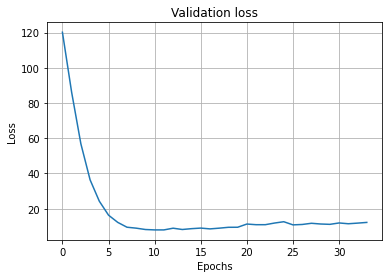

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import os

file1_path = 'plots/csv/run-baseline9_147_val-tag-epoch_loss.csv'

title_all ={'val_mAP': 'Validation mAP',
           'epoch_loss':'Validation loss',}
y_labels = {'val_mAP': 'mAP',
           'epoch_loss':'Loss'}

key_wrd = os.path.splitext( os.path.basename(file1_path) )[0].split('-')
metric = key_wrd[-1]
exp_name = key_wrd[1].split('_')[0]


csv_file1 = pd.read_csv(file1_path)
steps1 = csv_file1['Step']
val1 = csv_file1['Value']

plt.plot(steps1, val1)
# plt.ylim(0.0,0.9)
plt.grid('on')
plt.xlabel('Epochs')
plt.ylabel(y_labels[metric])
plt.title(title_all[metric])
# plt.legend(['person-baseline'])
out_name = 'plots/person-baseline_'+exp_name+'_'+metric
plt.tight_layout
if not os.path.exists(out_name+'.pdf'):
    plt.savefig(out_name+'.pdf', dpi=300, orientation='landscape', format='pdf')
print(exp_name+'_'+metric+'')
plt.show()

<ipython-input-2-afd74d13902f>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "boundingbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('pr curve interpolated.pdf', format='pdf', boundingbox='tight', pad=0)
<ipython-input-2-afd74d13902f>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('pr curve interpolated.pdf', format='pdf', boundingbox='tight', pad=0)


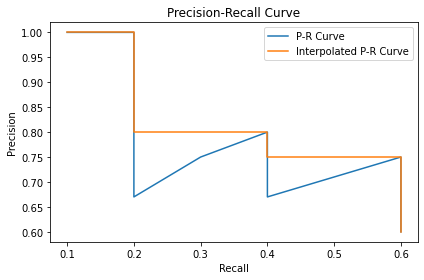

In [2]:
import matplotlib.pyplot as plt

recall = [0.1,0.2,0.2,0.3, 0.4, 0.4, 0.5, 0.6, 0.6, 0.6,]
precision = [1, 1,0.67,0.75,0.8,0.67,0.71,0.75,0.67,0.6,]
prec_smooth = [1, 1, 0.8,0.8,0.8,0.75,0.75,0.75,0.67,0.6,]

plt.plot(recall, precision)
plt.plot(recall, prec_smooth )
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['P-R Curve', 'Interpolated P-R Curve'])
plt.tight_layout()
plt.savefig('pr curve interpolated.pdf', format='pdf', boundingbox='tight', pad=0)

## FDA parameters plot

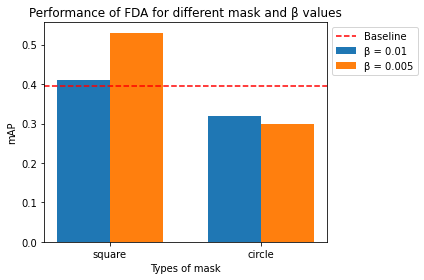

In [188]:
import numpy as np

labels = ['square', 'circle']

beta_1 = [0.41, 0.32]     ###0.01
beta_2 = [0.53, 0.3]    ###0.005

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, beta_1, width, label='\u03B2 = 0.01')
rects2 = ax.bar(x + width/2, beta_2, width, label='\u03B2 = 0.005')
base_line = ax.axhline(0.395, color='r', ls='--' )
base_line.set_label('Baseline')
# base_text = ax.annotate('Baseline',)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mAP')
ax.set_xlabel('Types of mask')
ax.set_title('Performance of FDA for different mask and \u03B2 values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.0,1.0), loc= 'upper left')
# ax.grid('on')

fig.tight_layout()
out_name = 'plots/'+'barplot'+'_'+'fda_exp'
if not os.path.exists(out_name+'.pdf'):
    plt.savefig(out_name+'.pdf', dpi=300, orientation='landscape', format='pdf',  bbox_inches='tight')
plt.show()

In [187]:
print('\u03B2')

β


## Augmentation effect plot

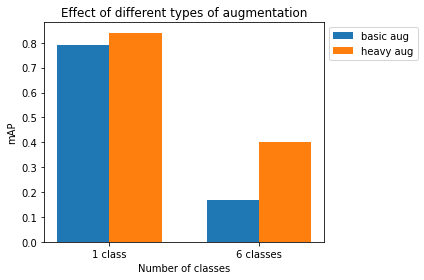

In [189]:
import numpy as np

labels = ['1 class', '6 classes']

beta_1 = [0.79, 0.17]     ###0.01
beta_2 = [0.84, 0.4]    ###0.005

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, beta_1, width, label='basic aug')
rects2 = ax.bar(x + width/2, beta_2, width, label='heavy aug')
# base_line = ax.axhline(0.8, color='r', ls='--' )
# base_line.set_label('Optimal-performance')
# base_text = ax.annotate('Baseline',)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mAP')
ax.set_xlabel('Number of classes')
ax.set_title('Effect of different types of augmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.0,1.0), loc= 'upper left')

fig.tight_layout()
out_name = 'plots/'+'barplot'+'_''aug_exp'
if not os.path.exists(out_name+'.pdf'):
    plt.savefig(out_name+'.pdf', dpi=300, orientation='landscape', format='pdf',  bbox_inches='tight')
plt.show()

## Effect of Warm/Decay

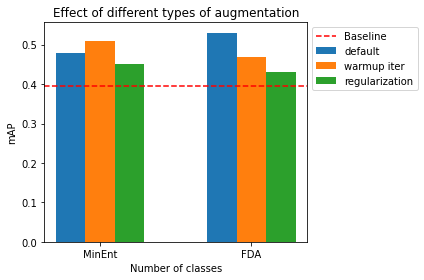

In [190]:
import numpy as np

labels = ['MinEnt', 'FDA']

beta_1 = [0.48, 0.53]     ### default
beta_2 = [0.51, 0.47]    ### warmup
beta_3 = [0.45, 0.43]              ### decay

x =    np.array([0.2, 0.8])      #np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, beta_1, width/3, label='default')
rects2 = ax.bar(x , beta_2, width/3, label='warmup iter')
rects3 = ax.bar(x + width/3, beta_3, width/3, label='regularization')
base_line = ax.axhline(0.395, color='r', ls='--' )
base_line.set_label('Baseline')
# base_text = ax.annotate('Baseline',)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mAP')
ax.set_xlabel('Number of classes')
ax.set_title('Effect of different types of augmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.0,1.0), loc= 'upper left')

fig.tight_layout()
out_name = 'plots/'+'barplot'+'_''warmup_exp'
if not os.path.exists(out_name+'.pdf'):
    plt.savefig(out_name+'.pdf', dpi=300, orientation='landscape', format='pdf',  bbox_inches='tight')
plt.show()